In [2]:
import numpy as np
import scipy.stats as st

import pandas as pd
import sympy

from pprint import pprint

from bayex import marginalize
from bayex.mendelian import Genotype
import bayex.families as fam

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, axis3d
import seaborn as sns

sns.set()

In [3]:
generators = [
    fam.unrelated,
    fam.third_cousins,
    fam.half_second_cousins,
    fam.second_cousins,
    fam.half_first_cousins,
    fam.first_cousins,
    fam.half_siblings,
    #fam.sibling_cousins,
    fam.siblings,
    fam.clones
]

In [4]:
q = sympy.Symbol('q')
g = Genotype({'AA': 1 - q, 'Aa': q})
families =  [f(default=g) for f in generators]
formulas = [f.infer_genotype('offspring').simplify() for f in families]

In [5]:
rcoeffs = np.array([f.cofficient_of_relationship for f in families])
s_ = lambda v: pd.Series(v, index=rcoeffs)
p_aa = lambda qval: s_([f.eval({q: qval})['aa'] for f in formulas])
p_num_aa_eq_0 = lambda qval, n: (1-p_aa(qval))**n
p_num_aa_ge_0 = lambda qval, n: 1 - p_num_aa_eq_0(qval, n)

In [6]:
pprint({r: (4*f['aa']).simplify() for r, f in zip(rcoeffs, formulas)})

{0.0: 1.0*q**2,
 0.0078125: q*(0.000878772290809869*q**7 - 0.0117884087791516*q**6 + 0.0743634259259291*q**5 - 0.283854166666669*q**4 + 0.695999710648149*q**3 - 1.08072916666667*q**2 + 0.9609375*q + 0.0078125),
 0.015625: q*(-0.00274348422496571*q**6 + 0.0339506172839506*q**5 - 0.194444444444444*q**4 + 0.587962962962963*q**3 - 1.0*q**2 + 0.921875*q + 0.015625),
 0.03125: q*(0.00790895061728394*q**5 - 0.0823688271604937*q**4 + 0.362702546296296*q**3 - 0.822916666666667*q**2 + 0.885416666666666*q + 0.03125),
 0.0625: q*(-0.0246913580246914*q**4 + 0.231481481481482*q**3 - 0.666666666666667*q**2 + 0.770833333333333*q + 0.0625),
 0.125: q*(0.104938271604938*q**3 - 0.425925925925926*q**2 + 0.569444444444444*q + 0.125),
 0.25: q*(-0.222222222222222*q**2 + 0.416666666666667*q + 0.25),
 0.5: q*(-0.0555555555555556*q + 0.5),
 1.0: 1.0*q}


In [7]:
p_aa(0.01)*4

0.000000    0.000100
0.007812    0.000173
0.015625    0.000247
0.031250    0.000400
0.062500    0.000701
0.125000    0.001307
0.250000    0.002541
0.500000    0.004994
1.000000    0.010000
dtype: float64

In [8]:
def p_aa_t(q, r):
    return 1/4*(np.outer(q-q**2, r) + np.outer(q**2, np.ones_like(r)))
p_one_t = lambda n, q, r: 1 - (1-p_aa_t(q, r))**n

In [9]:
1/800

0.00125

In [10]:
p_aa(0.01)

0.000000    0.000025
0.007812    0.000043
0.015625    0.000062
0.031250    0.000100
0.062500    0.000175
0.125000    0.000327
0.250000    0.000635
0.500000    0.001249
1.000000    0.002500
dtype: float64

In [11]:
p_aa_t(0.01, 0.5)

array([[0.0012625]])

In [12]:
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 2

In [13]:
qs_exp = -np.linspace(1, 3, 101)
qs = 10**(qs_exp)
rs_exp = -np.linspace(1, 8, 101)
rs = 2.0**(rs_exp)

qlab = ['10^(-%.0f)'%e for e in qs_exp]
rlab = ['1/%.0f'%(2**e) for e in -rs_exp]
print(rlab[::9])

['1/2', '1/3', '1/5', '1/7', '1/11', '1/18', '1/27', '1/43', '1/66', '1/102', '1/158', '1/244']


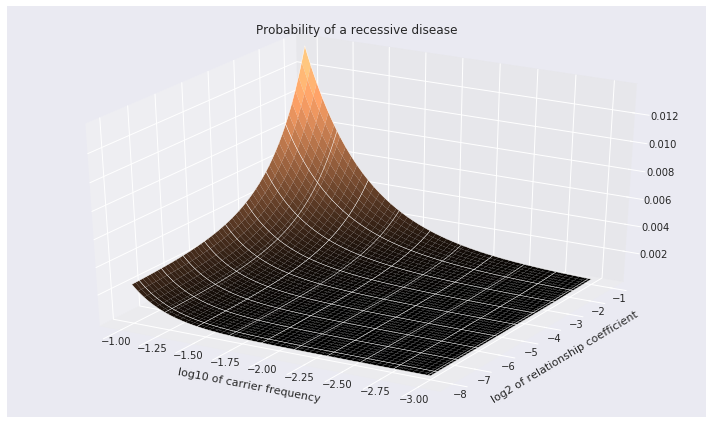

In [14]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(qs_exp, rs_exp)
v = p_aa_t(qs, rs).T
ax.plot_surface(X, Y, v, cmap='copper', rcount=100, ccount=100, linewidth=0.0)
ax.plot_wireframe(X, Y, v,
                  ccount=len(ax.xaxis.get_ticklabels())-1,
                  rcount=len(ax.yaxis.get_ticklabels())-1,
                  color='w',
                  linewidth=0.5)
ax.invert_xaxis()

ax.xaxis._axinfo['tick']['color'] = 'White'
ax.xaxis._axinfo['tick']['inward_factor'] = 1.0
ax.yaxis._axinfo['tick']['color'] = 'White'
ax.yaxis._axinfo['tick']['inward_factor'] = 0.5
ax.zaxis._axinfo['tick']['color'] = 'White'
ax.zaxis._axinfo['tick']['inward_factor'] = 0.5

ax.set(ylabel='log2 of relationship coefficient',
       xlabel='log10 of carrier frequency',
       title='Probability of a recessive disease')

ax.tick_params(axis='x', which='major', pad=-2)
ax.tick_params(axis='y', which='major', pad=-2)

fig.savefig('p_aa.pdf')
fig.tight_layout()

/nix/store/6kd9vyds39ca04kvrczmrpxvrvmp0b10-python3.6-matplotlib-2.1.2/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


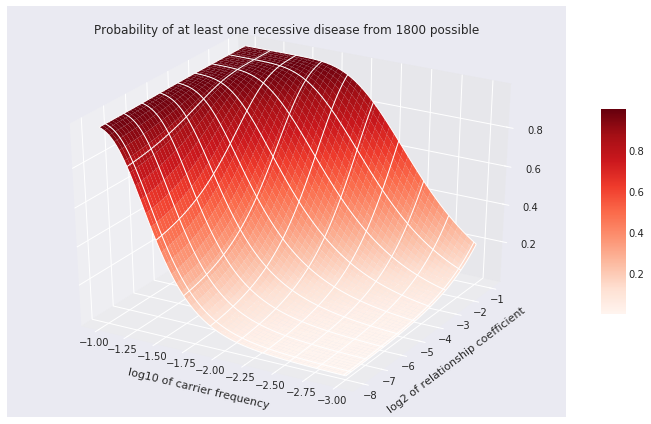

In [15]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(qs_exp, rs_exp)
v = p_one_t(1800, qs, rs).T
#print(X.shape, Y.shape, x.shape)

surf = ax.plot_surface(X, Y, v, cmap='Reds', rcount=100, ccount=100, linewidth=0.0, alpha=1.0)
ax.plot_wireframe(X, Y, v,
                  ccount=len(ax.xaxis.get_ticklabels())-1,
                  rcount=len(ax.yaxis.get_ticklabels())-1,
                  colors='w',
                  linewidth=1,
                  alpha=1.0)
eps = 0.01
ax.contour(X, Y, v, colors='White', levels=np.arange(0.0, 1.2, 0.1), linewidth=1, alpha=0.5)
ax.invert_xaxis()

ax.xaxis._axinfo['tick']['color'] = 'White'
#ax.xaxis._axinfo['tick']['inward_factor'] = 1.0
ax.yaxis._axinfo['tick']['color'] = 'White'
#ax.yaxis._axinfo['tick']['inward_factor'] = 0.5
ax.zaxis._axinfo['tick']['color'] = 'White'
#ax.zaxis._axinfo['tick']['inward_factor'] = 0.5

ax.set(ylabel='log2 of relationship coefficient',
       xlabel='log10 of carrier frequency',
       title='Probability of at least one recessive disease from 1800 possible')

ax.tick_params(axis='x', which='major', pad=-2)
ax.tick_params(axis='y', which='major', pad=-2)

fig.tight_layout()
fig.colorbar(surf, shrink=0.5, aspect=8)
plt.show()
fig.savefig('at_least_one.pdf')

/nix/store/6kd9vyds39ca04kvrczmrpxvrvmp0b10-python3.6-matplotlib-2.1.2/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


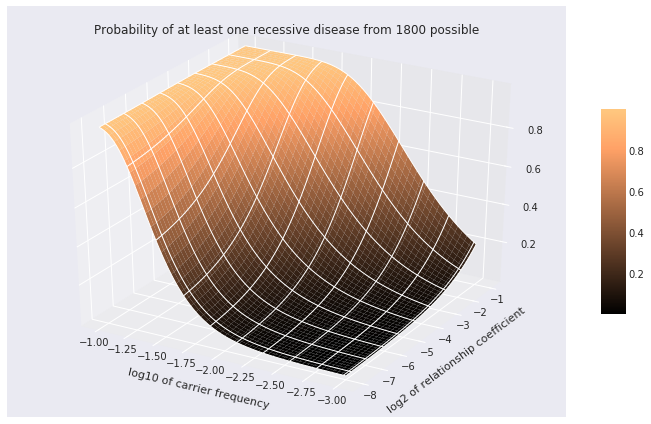

In [21]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(qs_exp, rs_exp)
v = p_one_t(1800, qs, rs).T
#print(X.shape, Y.shape, x.shape)

surf = ax.plot_surface(X, Y, v, cmap='copper', rcount=100, ccount=100, linewidth=0.0, alpha=1.0)
ax.plot_wireframe(X, Y, v,
                  ccount=len(ax.xaxis.get_ticklabels())-1,
                  rcount=len(ax.yaxis.get_ticklabels())-1,
                  colors='w',
                  linewidth=1,
                  alpha=1.0)
eps = 0.01
ax.contour(X, Y, v, colors='White', levels=np.arange(0.0, 1.2, 0.1), linewidth=1, alpha=0.5)
ax.invert_xaxis()

ax.xaxis._axinfo['tick']['color'] = 'White'
#ax.xaxis._axinfo['tick']['inward_factor'] = 1.0
ax.yaxis._axinfo['tick']['color'] = 'White'
#ax.yaxis._axinfo['tick']['inward_factor'] = 0.5
ax.zaxis._axinfo['tick']['color'] = 'White'
#ax.zaxis._axinfo['tick']['inward_factor'] = 0.5

ax.set(ylabel='log2 of relationship coefficient',
       xlabel='log10 of carrier frequency',
       title='Probability of at least one recessive disease from 1800 possible')

ax.tick_params(axis='x', which='major', pad=-2)
ax.tick_params(axis='y', which='major', pad=-2)

fig.tight_layout()
fig.colorbar(surf, shrink=0.5, aspect=8)
plt.show()
fig.savefig('at_least_one.pdf')

In [699]:
ax.yaxis._axinfo

{'axisline': {'color': 'white', 'linewidth': 0.0},
 'color': (0.9, 0.9, 0.9, 0.5),
 'grid': {'color': 'white', 'linestyle': '-', 'linewidth': 1.0},
 'i': 1,
 'juggled': (0, 1, 2),
 'label': {'ha': 'center', 'va': 'center'},
 'tick': {'color': 'White',
  'inward_factor': 0.2,
  'linewidth': 1.0,
  'outward_factor': 0.1},
 'tickdir': 0}

In [304]:
births

136900000.0

In [ ]:
from matplotlib.ticker import FixedFormatter, FixedLocator
labels = {
    's': -1,
    's/2': -2,
    'c': -3,
    'c/2': -4,
    '2c': -5,
    '2c/2': -6,
}

print(ax.get_ylim())
k = ax.get_ylim()[1] / qs_exp[-1]

ax.yaxis.set_minor_locator(FixedLocator([l*k for l in labels.values()]))
ax.yaxis.set_minor_formatter(FixedFormatter(list(labels.keys())))
ax.tick_params(axis='y', which='minor', bottom='off', pad=20,)
